<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

#### <span style="color:darkred">__Part 1: Data Exploration__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><br><span style="color:darkred">__Part 2: Models__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">Part 1: </span><span style="color:darkblue">L1 Prediction from ELL Writing Samples</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

![alt text](../data/language/lang8.png "Title")

__Summary:__
> In my previous profession, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language. Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (NLTK Abbreviations: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> --<li>--<li>--

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# from nltk.corpus import brown
# nltk.download('brown')

In [2]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns
from collections import Counter
import re

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, median_test, f_oneway

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [3]:
# load and close files
def get_text(link):
    with open(link) as f:
        output = f.read()
    return output

In [4]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [5]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
blog.info()

# POS Table for reference
poscv = pd.read_csv('../data/pos.csv')
poscv = poscv.iloc[0:17]
poscv.columns = ['Set1','Set 2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15709 entries, 0 to 15708
Data columns (total 6 columns):
Unnamed: 0    15709 non-null int64
id            15709 non-null int64
time          15709 non-null object
title         15709 non-null object
content       15709 non-null object
language      15709 non-null object
dtypes: int64(2), object(4)
memory usage: 736.4+ KB


In [6]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')

# Clean Data
del blog['Unnamed: 0']
blog.language = blog.language.mask(blog.language == 'Mandarin', 'Traditional Chinese').replace(['Persian', 'Arabic',
        'Bulgarian', 'Swedish', 'Slovenian', 'Slovak', 'Malay', 'Turkish','Romanian', 'Czech', 'Danish', 'Vietnamese',
        'Norwegian','Serbian','Other language','Lithuanian', 'Ukrainian', 'Finnish','Estonian','Bengali','Russian', 
        'Spanish','French', 'German', 'Cantonese','Mongolian', 'Tagalog', 'Polish', 'Dutch','Italian', 'Portuguese(Brazil)', 
        'Thai', 'Indonesian', 'Cantonese','Urdu', 'Hungarian'], np.nan)
blog = blog.dropna()

del blog['title']
del blog['time']

In [7]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14473 entries, 0 to 15689
Columns: 3 entries, id to language
dtypes: int64(1), object(2)

In [8]:
blog.head()

,id,content,language
0,1,I will visit Silicon Valley in California bet...,Japanese
1,1,My parents want to take their Chinese guests ...,Japanese
2,1,Do you know a Japanese animation (and novel) ...,Japanese
3,2,I went to watch a featherweight throne jump-o...,Japanese
4,2,There is a traditional custum that a blood re...,Japanese


In [9]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [10]:
def lettercheck(val):
    reLetters = re.compile('[^a-zA-Z]')
    onlyletters = reLetters.sub('', val)
    return len(onlyletters)/len(val)

In [11]:
blog['letters_per'] = blog.content.apply(lettercheck)
print('Removing Blogs with less than 70% letter percentage: {}'.format(blog.loc[blog['letters_per'] <= .7].content.count()))
blog = blog.loc[blog['letters_per'] > .7]

Removing Blogs with less than 70% letter percentage: 1386


<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

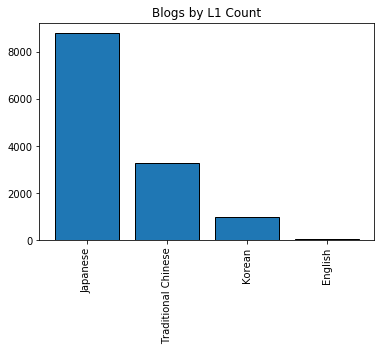

In [12]:
vals = list(blog.language.value_counts().values)
languages = list(blog.language.value_counts().index)
plt.figure(figsize(6,4))
plt.bar(languages,vals,edgecolor='black')
plt.title('Blogs by L1 Count')
plt.xticks(rotation='vertical')
plt.show()

In [13]:
print("Posts by 'Native' English Speakers: {}".format(blog.id.loc[blog.language == 'English'].count()))

Posts by 'Native' English Speakers: 63


<a id="nlp"></a>

### <span style="color:darkred">NLP: Spell Check, Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

__Word Level Ranking__

In [14]:
WORDS = Counter(map(str.lower, brown.words()))

__TextBlob__

In [15]:
WORDS = Counter(map(str.lower, brown.words()))

In [16]:
%%time
blob = blog.content.apply(lambda val: textblob.TextBlob(val))

CPU times: user 176 ms, sys: 2.87 ms, total: 178 ms
Wall time: 178 ms


In [17]:
def posbigram(val):
    l = []
    bigramlist = []
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        bigrm = list(nltk.bigrams(l))
        
        for bigram in bigrm:
            bigramlist.append('-'.join(bigram))
        
    return bigramlist

In [18]:
%%time
blog['wc'] = blob.apply(len)
blog['sc'] = blob.apply(lambda val: len(val.sentences))
blog['tokens'] = blob.apply(lambda val: val.words)
blog['pos'] = blob.apply(lambda val: [v[1] for v in val.tags])
blog['pos2'] = blob.apply(posbigram)
blog['sent_pol'] = blob.apply(lambda val: val.sentiment[0])
blog['sent_subj'] = blob.apply(lambda val: val.sentiment[1])

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/util.py:491: DeprecationWarning:

generator 'ngrams' raised StopIteration



CPU times: user 3min 55s, sys: 4.32 s, total: 3min 59s
Wall time: 4min 2s


__Backup File__

__Bar Plots__

In [19]:
lang = list(blog.language.unique())

def count_vals_df(df,col):
    return pd.DataFrame(data = [Counter(np.concatenate(np.array(df[col][blog.language == l]))) for l in lang], 
                        index = [l for l in lang]).T.fillna(0).sort_values(by='Japanese',ascending=False)

def graphsum(df):
    for l in df:
        df[l] = df[l]/df[l].sum()
    return df

def graph_bar(df,name,dim):
    graphsum(df).plot.bar(rot=0,figsize=dim)
    plt.title(name)
    plt.show()
    
def graph_hbar(df,name,dim):
    graphsum(df).plot.barh(rot=0,figsize=dim)
    plt.title(name)
    plt.show()

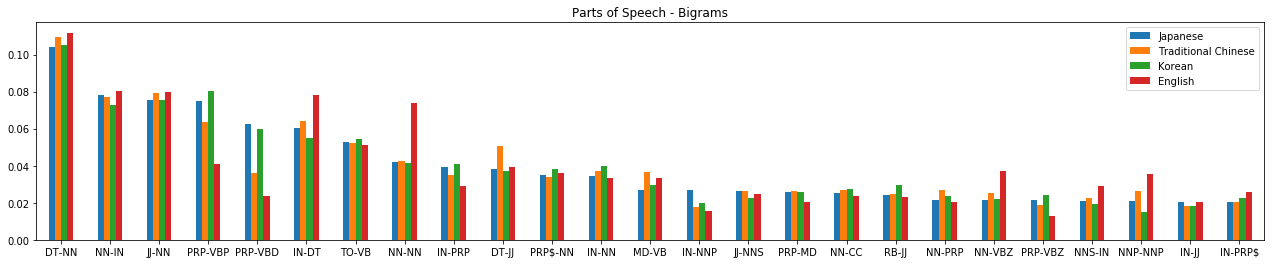

In [20]:
pos2 = count_vals_df(blog,'pos2').iloc[0:25]
graph_bar(pos2,'Parts of Speech - Bigrams',(22, 4))

_There is a lower English sample count so higher variance is expected._

<a id="feature"></a>

# <span style="color:darkblue">2. Feature Processing:</span>  <a href='#top'>(top)</a>

In [21]:
def create_dummy_count_df(df,col,keep=[]):
    colset = set(df[col].sum())
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    newdf = pd.DataFrame()
    
    for c in colset:
        newdf[col+'_'+str(c)] = df[col].apply(lambda val: val.count(c) )
        
    print('Created dummy counter for {} features'.format(col))
        
    return newdf

In [22]:
%%time
pos2 = create_dummy_count_df(blog,'pos2')
pos2 = pos2.loc[:, pos2.sum() > 100]

Created dummy counter for pos2 features
CPU times: user 2min 4s, sys: 22.3 s, total: 2min 26s
Wall time: 2min 27s


In [30]:
blog_data = pd.DataFrame(blog[['id','language','wc','sc','sent_pol','sent_subj']])
tags = [blog_data,pos2]
features = tags[0]
tags = tags[1:]
for i in range(len(tags)):
    features = features.merge(tags[i], how='outer', left_index=True, right_index=True)

In [32]:
%%time
features.to_csv('blogfeatures.csv')
# features_user.to_csv('userblogfeatures.csv')

CPU times: user 4.76 s, sys: 311 ms, total: 5.07 s
Wall time: 5.1 s


# <span style="color:darkblue">3. Statistical Analysis:</span>  <a href='#top'>(top)</a>

__Reject Outliers__

In [69]:
from statsmodels import robust

def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~numpy.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~numpy.isnan(data)].sort_values()

# lanlenseries = [reject_outliers(blog.char_count[blog.language == l]) for l in list(blog.language.unique())]

__Create Analysis Set__

In [70]:
import_features = ['wc','pos2_NN-MD','sc','pos2_DT-JJ', 'pos2_PRP-VBD', 'pos2_NN-PRP', 'pos2_PRP-RB', 'pos2_MD-VB', 'pos2_VB-PRP', 'pos2_PRP-DT', 'pos2_WRB-NN', 'pos2_RB-JJ', 'pos2_RB-MD', 'pos2_IN-NNP', 'pos2_JJ-PRP', 'pos2_JJR-CC', 'pos2_DT-RBS', 'pos2_NN-IN', 'pos2_VBG-NNP', 'pos2_NNP-NNP', 'pos2_CC-PRP$', 'pos2_NNS-JJ', 'pos2_JJ-VBP', 'pos2_VBP-VB', 'pos2_WRB-MD', 'pos2_NNP-IN', 'pos2_VB-NN', 'pos2_NNP-JJ', 'pos2_VBZ-JJ', 'pos2_NNP-POS', 'pos2_VBD-TO', 'pos2_CC-WRB', 'pos2_CD-NN', 'pos2_IN-VBG', 'pos2_PRP-PRP', 'pos2_RB-DT']
full_features = import_features + ['language','id']


analysis = features[full_features]
analysis2 = analysis.groupby(['id','language']).mean()
analysis2.reset_index(inplace=True)
print("'Native' English Speaker Count: {}".format(analysis2.id.loc[analysis2.language == 'English'].count()))

'Native' English Speaker Count: 13


__Plot Hist__

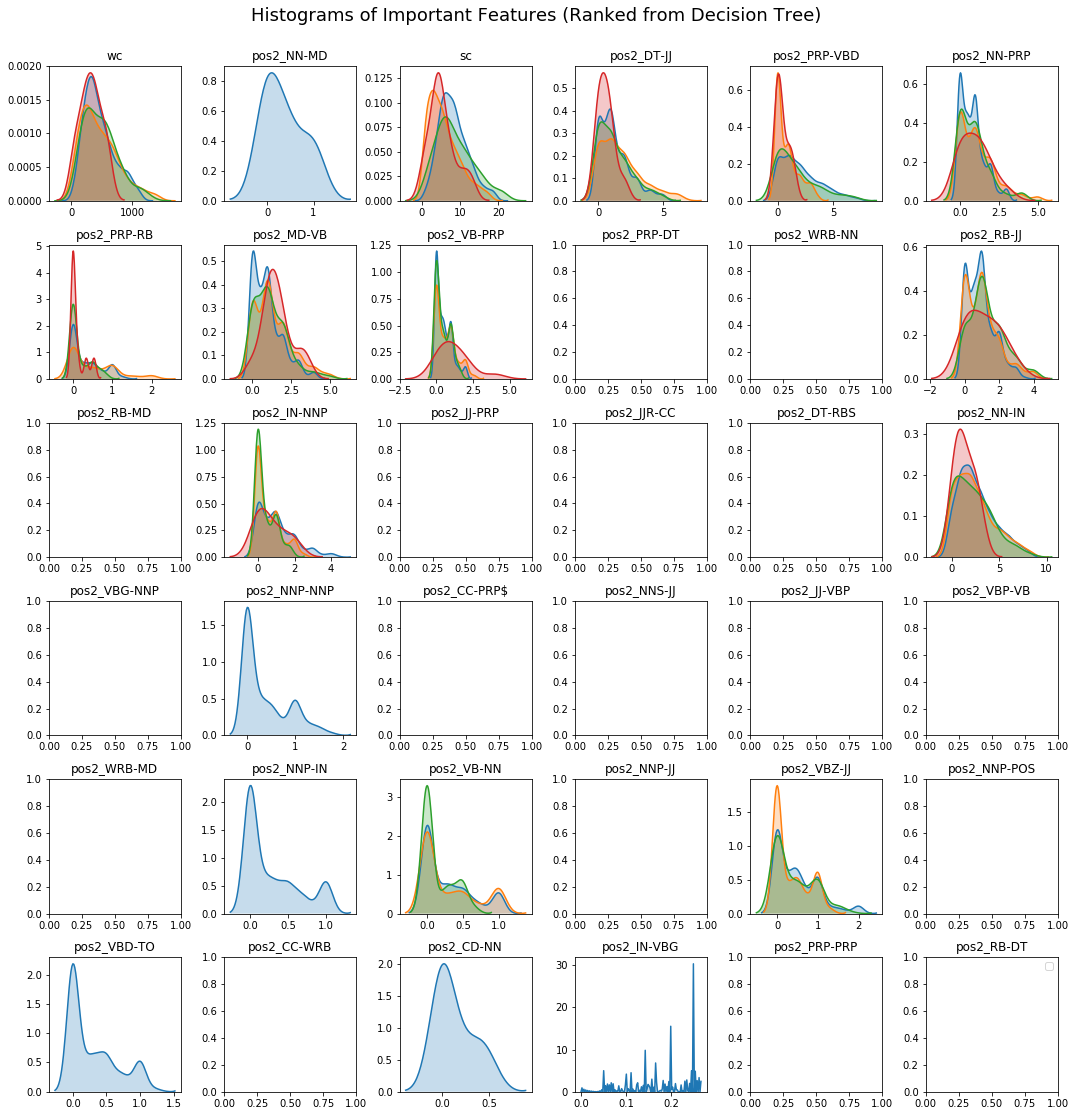

In [68]:
i = 1
fig=plt.figure(figsize=(15,15))
for pos in import_features:
    plt.subplot(6, 6, i)
    i = i + 1
    
    for g in [MEDIAN_reject_outliers(analysis2[pos][analysis2.language == l]) for l in lang]:
        sns.kdeplot(g,legend=None,kernel='gau',shade=True)
#         plt.hist(g,alpha=0.8)
        plt.title(pos)

fig.suptitle('Histograms of Important Features (Ranked from Decision Tree)', fontsize=18, y=1.03)
plt.tight_layout()
plt.legend(lang)
plt.show()

__Correlations (of top features by decision tree importance)__

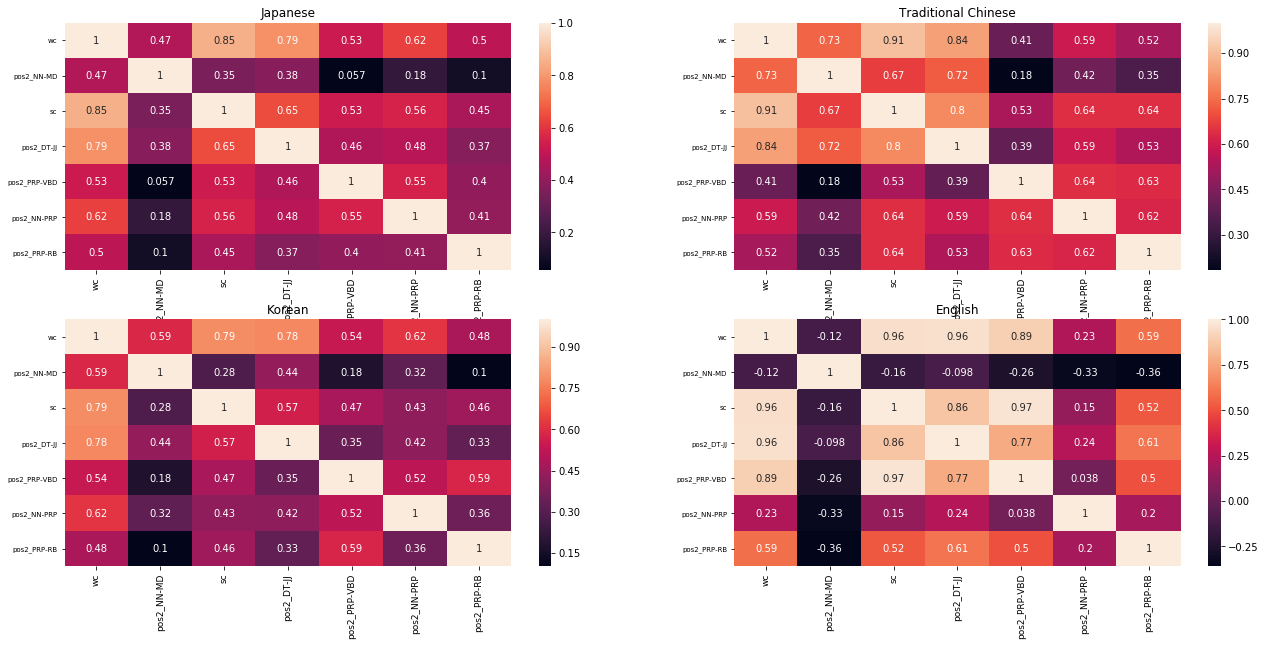

In [54]:
# corr = analysis.corr(); print(corr)
i = 1
fig=plt.figure(figsize=(22,10))

for ind,g in enumerate([(analysis2[['wc','pos2_NN-MD','sc','pos2_DT-JJ', 'pos2_PRP-VBD', 'pos2_NN-PRP', 'pos2_PRP-RB']][analysis2.language == l]) for l in lang]):
    plt.subplot(2, 2, i)
    i = i + 1
    
    corr = g.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
    plt.title(lang[ind])
    plt.xticks(rotation='vertical',fontsize = 9)
    plt.yticks(rotation='horizontal',fontsize = 7)
    
plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

In [55]:
def mw_test(a,b):
    stat,p = mannwhitneyu(a,b, use_continuity=True, alternative=None)
    return stat,p

def mood_test(a,b,c,d):
    stat, p, med, tbl = median_test(a,b,c,d)
    return stat,p

def f1way_test(a,b,c,d):
    f,b = f_oneway(a,b,c,d)
    return f,b

import warnings
warnings.filterwarnings('ignore')

__Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

In [56]:
print('[Japanese -- Chinese]')

for pos in import_features:
    g = [reject_outliers(analysis2[pos][analysis2.language == l]) for l in lang]
    stat,p = mw_test(g[0],g[1])
    vals = 'stat={}, p={}'.format(stat,p)
    if p < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))
poscv

[Japanese -- Chinese]
wc:stat=741183.5, p=0.1809708615717031
pos2_NN-MD:stat=0.0, p=0.0
sc:stat=483404.5, p=8.823378432483402e-61
pos2_DT-JJ:stat=667598.0, p=9.615187539898025e-12
pos2_PRP-VBD:stat=426543.0, p=3.615048615755736e-70
pos2_NN-PRP:stat=730790.0, p=4.14150561740865e-07
pos2_PRP-RB:stat=662369.5, p=2.2271282828598247e-08
pos2_MD-VB:stat=649434.5, p=1.5528800242528952e-16
pos2_VB-PRP:stat=719393.0, p=0.00010205631700338604
pos2_PRP-DT:stat=0.0, p=0.0
pos2_WRB-NN:stat=0.0, p=0.0
pos2_RB-JJ:stat=782239.5, p=0.07691618676880912
pos2_RB-MD:stat=0.0, p=0.0
pos2_IN-NNP:stat=560265.0, p=4.352893891251597e-33
pos2_JJ-PRP:stat=0.0, p=0.0
pos2_JJR-CC:stat=0.0, p=0.0
pos2_DT-RBS:stat=0.0, p=0.0
pos2_NN-IN:stat=710127.0, p=0.007073809023446388
pos2_VBG-NNP:stat=0.0, p=0.0
pos2_NNP-NNP:stat=0.0, p=0.0
pos2_CC-PRP$:stat=0.0, p=0.0
pos2_NNS-JJ:stat=0.0, p=0.0
pos2_JJ-VBP:stat=0.0, p=0.0
pos2_VBP-VB:stat=0.0, p=0.0
pos2_WRB-MD:stat=0.0, p=0.0
pos2_NNP-IN:stat=0.0, p=0.0
pos2_VB-NN:stat=73203

,Set1,Set 2
0,CC coordinating conjunction,"PRP personal pronoun I, he, she"
1,CD cardinal digit,"PRP$ possessive pronoun my, his, hers"
2,DT determiner,"RB adverb very, silently,"
3,EX existential there,"RBR adverb, comparative better"
4,FW foreign word,"RBS adverb, superlative best"
5,IN preposition/subordinating conjunction,RP particle give up
6,JJ adjective 'big',TO to go 'to' the store.
7,"JJR adjective, comparative 'bigger'",UH interjection errrrrrrrm
8,"JJS adjective, superlative 'biggest'","VB verb, base form take"
9,LS list marker 1),"VBD verb, past tense took"


__B. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [58]:
for pos in import_features:
    g = [(analysis2[pos][analysis2.language == l]) for l in lang]
    
    stat,p = mood_test(g[0],g[1],g[2],g[3])
    vals = 'stat={}, p={}'.format(stat,p)
    if p < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))

wc:stat=4.107243556764018, p=0.25011419707023425
pos2_NN-MD:stat=36.544218323719655, p=5.7451841534589574e-08
sc:stat=159.3761836766187, p=2.498923634942174e-34
pos2_DT-JJ:stat=41.08154220454478, p=6.283909817408949e-09
pos2_PRP-VBD:stat=169.36922841840914, p=1.741159346009395e-36
pos2_NN-PRP:stat=31.13737370496607, p=7.952739622240914e-07
pos2_PRP-RB:stat=18.685423914342987, p=0.00031755220932267294
pos2_MD-VB:stat=49.722366600852226, p=9.154322182138493e-11
pos2_VB-PRP:stat=26.842492622493154, p=6.3523930261055075e-06
pos2_PRP-DT:stat=5.824469150599965, p=0.12046958126243401
pos2_WRB-NN:stat=13.70059086443232, p=0.0033423687324289457
pos2_RB-JJ:stat=13.67892968255348, p=0.003376417254454132
pos2_RB-MD:stat=54.1493543874208, p=1.0427084506191076e-11
pos2_IN-NNP:stat=84.22899837386609, p=3.7987748865933894e-18
pos2_JJ-PRP:stat=3.862959379230391, p=0.27664734249559625
pos2_JJR-CC:stat=7.2079133418082755, p=0.06555798648570711
pos2_DT-RBS:stat=3.318398736825271, p=0.3450900815960119
pos2

In [ ]:
# print(len(*blog['language'].isin(lang)))

p-value is less than 5% and disproves the null hypothesis. With regards to error percentage, L1 language samples have different distributions.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [59]:
for pos in import_features:
    g = [(analysis2[pos][analysis2.language == l]) for l in lang]
    
    f,b = f1way_test(g[0],g[1],g[2],g[3])
    vals = 'f={}, b={}'.format(f,b)
    if b < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))

wc:f=3.086146351702986, b=0.02619776752362215
pos2_NN-MD:f=39.4729153134358, b=5.239770278865566e-25
sc:f=15.391983834423325, b=6.169302353683429e-10
pos2_DT-JJ:f=23.685793178322452, b=3.807113494708649e-15
pos2_PRP-VBD:f=29.00251746814844, b=1.772743164354965e-18
pos2_NN-PRP:f=19.340325202308296, b=2.0389494483267796e-12
pos2_PRP-RB:f=12.820520969201613, b=2.537877957250148e-08
pos2_MD-VB:f=26.088257043942292, b=1.1853776954370131e-16
pos2_VB-PRP:f=18.78614748637037, b=4.545821241585367e-12
pos2_PRP-DT:f=14.276014807152922, b=3.0979362523372578e-09
pos2_WRB-NN:f=10.78700389635189, b=4.769511101819102e-07
pos2_RB-JJ:f=9.05652489380294, b=5.745503683816565e-06
pos2_RB-MD:f=34.962485345298134, b=3.3584398294021315e-22
pos2_IN-NNP:f=8.431691399739348, b=1.4076148901219509e-05
pos2_JJ-PRP:f=18.670741223606974, b=5.371901849709534e-12
pos2_JJR-CC:f=10.030443383108274, b=1.417416142872369e-06
pos2_DT-RBS:f=3.3014099754803525, b=0.01952999727509932
pos2_NN-IN:f=2.3550789228723064, b=0.0700710

p-value is less than 5% and disproves the null hypothesis. L1 samples have different distributions.

<a id="output"></a>

# <span style="color:darkblue">4. Output:</span>  <a href='#top'>(top)</a>

__Save Data:__

In [ ]:
%%time
features.to_csv('blogfeatures.csv')

----